In [1]:
import os
import pandas as pd
import numpy as np
import pickle

from sklearn.utils.class_weight import compute_class_weight
from keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import *

from keras import optimizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, Callback

import matplotlib.pyplot as plt
plt.style.use('seaborn')

Using TensorFlow backend.


---

### First, copy-paste the setup from the notebook that produced the pretrained classweights.
This time we load also the test-data into memory
(Note to self: learn how to make imports from other notebooks...)

In [2]:
global_params = pickle.load(open("global_params.p", "rb"))
unique_words = global_params['unique_words']
num_words = global_params['num_words']
padded_length = global_params['padded_length']
n_classes = global_params['n_classes']
class_weights = global_params['class_weights']

global_params

{'unique_words': 277303,
 'num_words': 277304,
 'padded_length': 679,
 'n_classes': 6,
 'class_weights': array([ 1.26825655,  0.72736371,  0.27602776, 13.23801959, 30.29201502,
         9.49559404])}

In [3]:
sample_n = 50_000

In [4]:
X_train = np.load(os.path.join("data", "Kdata", "X_train.npy"))[-sample_n:]
y_train = np.load(os.path.join("data", "Kdata", "y_train.npy"))[-sample_n:]
X_val = np.load(os.path.join("data", "Kdata", "X_val.npy"))[-sample_n:]
y_val = np.load(os.path.join("data", "Kdata", "y_val.npy"))[-sample_n:]
X_test = np.load(os.path.join("data", "Kdata", "X_test.npy"))
y_test = np.load(os.path.join("data", "Kdata", "y_test.npy"))

In [18]:
from keras import backend as K

# Custom metrics.
# Note that any metric is computed per batch during training
# (hence one needs large batches for it to make sense).
# Also, there is the implicit 0.5 treshold in the K.round function below

def macroPrec(y_true, y_pred):
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    positives = K.sum(K.round(y_pred), axis=0)
    precision = true_positives / (positives + K.epsilon())

    macroPrec = K.mean( precision )
    
    return macroPrec


def macroRecall(y_true, y_pred):
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    actual_ones = K.sum(K.round(K.clip(y_true, 0, 1)), axis=0)
    recall = true_positives / (actual_ones + K.epsilon())

    macroRecall = K.mean( recall )
    
    return macroRecall


def macroF1(y_true, y_pred):
    
    def recall(y_true, y_pred):

        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
        actual_ones = K.sum(K.round(K.clip(y_true, 0, 1)), axis=0)
        recall = true_positives / (actual_ones + K.epsilon())
        return recall

    
    def precision(y_true, y_pred):
        
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
        positives = K.sum(K.round(K.clip(y_pred, 0, 1)), axis=0)
        precision = true_positives / (positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    macroF1 = K.mean( 2*((precision*recall)/(precision+recall+K.epsilon())) )
    
    return macroF1



# Custom loss functions
# No clippping or rounding as those are not differentiable
# Note to self: these functions are already taking into account class imbalances, so remeber
# not to set the class_weight argument in fitting method when using them as the loss 

# semi macroF1
def fuzzy_macroF1_flip(y_true, y_pred):

    true_positives = K.sum(y_true * y_pred, axis=0)
    
    actual_ones = K.sum(y_true, axis=0)
    recall = true_positives / (actual_ones + K.epsilon())

    positives = K.sum(y_pred, axis=0)
    precision = true_positives / (positives + K.epsilon())
    
    macroF1 = 2 * K.mean( precision*recall / (precision + recall + K.epsilon()) ) 
    
    return 1-macroF1


# # weighted categorical crossentropy
# def my_crossE(y_true, y_pred):
    
#     class_entropy = K.sum(y_true * K.log(y_pred+K.epsilon()), axis=0)
#     weighted_entropy = K.mean(class_weights * class_entropy)
#     return -4E-4 * weighted_entropy  # arbitrary coefficient to make it close to [0-1] interval


# take average of the last two, because why not
def my_loss(y_true, y_pred):
    # return 0.5*(fuzzy_macroF1_flip(y_true, y_pred) + my_crossE(y_true, y_pred))
    
    true_positives = K.sum(y_true * y_pred, axis=0)
    
    actual_ones = K.sum(y_true, axis=0)
    recall = true_positives / (actual_ones + K.epsilon())

    positives = K.sum(y_pred, axis=0)
    precision = true_positives / (positives + K.epsilon())
    
    macroF1p2 = K.mean( precision*recall / (precision + recall + K.epsilon()) )
    
    class_entropy = K.sum(y_true * K.log(y_pred+K.epsilon()), axis=0)
    weighted_entropy = K.mean(class_weights * class_entropy)
    
    return 0.5 - macroF1p2 - 1E-4 * weighted_entropy

In [7]:
# auxiliary functions
    

# to plot the learning history,
# i.e. loss and metrics on each train_batch and validation_batch
def plot_history(history):
    
    plt.figure(figsize=(12, 5))
    
    loss = history['loss']
    val_loss = history['val_loss']
    x = range(1, len(loss) + 1)
    
    plt.subplot(1, 3, 1)    
    plt.plot(x, loss, 'ob', label='Training loss')
    plt.plot(x, val_loss, '-b', label='Validation loss')
    plt.title('Training and val losses') 
    plt.legend()
    
    all_metrics = np.array(list(set(history.keys()) - set(['loss', 'val_loss', 'lr'])))
    metrics = all_metrics[[not metric.startswith('val_') for metric in all_metrics]]
    plt.subplot(1, 3, 2)
    markers = ['b', 'r',  'g', 'y', 'm', 'c', 'k']
    marker = zip(markers, markers)
    for metric in metrics:
        results = history[metric]
        val_results = history['val_'+metric]
        mark1, mark2 = next(marker)
        plt.plot(x, results, 'o'+mark1, label=metric)
        plt.plot(x, val_results, '-'+mark2, label='Validation '+metric)
        plt.title('Training and val metrics')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    lr = history['lr'] # learning rate
    plt.plot(x, lr, 'k', label='Learning rate')
    plt.title('Learning rate')  
    plt.legend()
    

# choose callbacks to be given in model.fit(...)
class WakeEmbedding(Callback):
    def __init__(self, rel_lr_treshold):
        self.rel_lr_treshold = rel_lr_treshold
    
    def on_train_begin(self, logs={}):
        self.init_lr =  K.eval(self.model.optimizer.lr)
        
    def on_epoch_begin(self, epoch, logs={}):
        lr =  K.eval(self.model.optimizer.lr)
        if (lr / self.init_lr) <= self.rel_lr_treshold:
            self.model.layers[0].trainable = True
        print("Embedding trainable:", self.model.layers[0].trainable)

        
callbacks = [ReduceLROnPlateau(factor=0.5,\
                               monitor='val_macroF1', mode='max', patience = 1),
             EarlyStopping(monitor='val_macroF1', mode='max', patience=2),
             WakeEmbedding(0.9)
            ]


# some other global learning settings

batch_size = 3000
# defualt lr = 0.001
optimizer = optimizers.Adam(lr=0.002, beta_1=0.9, beta_2=0.999,\
                            epsilon=None, decay=0.0, amsgrad=False)
my_metrics = [macroPrec, macroF1, macroRecall] #, my_crossE, fuzzy_macroF1_flip, my_loss]

---

In [8]:
# the workhorse

class BlackBox():
    
    def __init__(self, layers, loss, metrics, callbacks=callbacks, class_weight=class_weights, epochs=3,\
                 embedd = None, embedd_dims=[None]*3, train_weights=False):
        
        self.layers = layers
        self.loss = loss
        self.metrics = metrics
        self.callbacks = callbacks
        self.class_weight = class_weight
        self.epochs = epochs
        self.train_weigts = train_weights
        self.history = None
        self.test_results = None
        
        self.model = Sequential()
        if embedd:
            self.input_dim = embedd_dims[0] # num_words
            self.output_dim = embedd_dims[1] # dimension of the embedding space
            self.input_length = embedd_dims[2] # padded_length
            with open(embedd, "rb") as f:
                self.embedd_weights = pickle.load(f)
            
            self.model.add(Embedding(input_dim=self.input_dim,\
                                     output_dim=self.output_dim,\
                                     input_length=self.input_length,\
                                     weights=self.embedd_weights,\
                                     trainable=self.train_weigts))
            self.model.layers[0].trainable = self.train_weigts  # szczeżonego panbug szczeże
            
        for layer in layers:
            self.model.add(layer)
            
        self.model.add(Dense(n_classes, activation='softmax'))
        self.model.compile(loss=self.loss, optimizer=optimizer, metrics=self.metrics)
    
    def summary(self):
        return self.model.summary()
    
    def fit(self, epochs=50):
        self.history = self.model.fit(
            X_train, y_train,
            class_weight=self.class_weight,
            epochs=self.epochs,
            batch_size=batch_size,
            #validation_split=0.1,
            validation_data=(X_val, y_val),
            callbacks=self.callbacks,
            verbose = 1        
            )
        
    def reset(self):
        
        self.history = None
        self.test_results = None
        self.model.compile(loss=self.loss, optimizer=optimizer, metrics=self.metrics)
        
    def evaluate(self, X_test, y_test):
        print(f'Loss function: {self.loss.__name__ if callable(self.loss) else self.loss}. Metrics: {[metric.__name__ if callable(metric) else metric for metric in self.metrics]}')
        print("Predicting for X_test, comparing with y_test")
        self.test_results = self.model.evaluate(X_test, y_test)
        return self.test_results
    
    def plot(self):
        plot_history(self.history.history)
        
    def save_embedd(self, name):
        file = os.path.join("my_embeddings", f"weights_{name}.p")
        with open(file, 'wb') as f:
            pickle.dump(self.model.layers[0].get_weights(), f)
        
    def Ksave(self, name):
        file = os.path.join("my_embeddings", f"Kmodel_from_{name}.h5")
        self.model.save(file)
    
    def save_hist(self, name):
        file = os.path.join("my_embeddings", f"history_of_{name}.p")
        with open(file, 'w') as f:
            json.dump(self.history.history, f) 


In [9]:
custom_objects={'macroPrec': macroPrec,\
                'macroF1': macroF1,\
                'macroRecall': macroRecall,\
#                 'my_crossE': my_crossE,\
                 'fuzzy_macroF1_flip': fuzzy_macroF1_flip,\
                'my_loss': my_loss
               }

---
---

In [10]:
import gc
gc.collect()

7

In [11]:
embedd_file_1 = os.path.join("my_embeddings", "weights_50dim_GlblAvg_MyLoss_10epochs.p")
embedd_file_2 = os.path.join("my_embeddings", "weights_50dim_GlblAvg_F1flip_10epochs.p")

# Loss = *my_loss*

---

### Dense nets

In [43]:
# embedding: keras layer, trained
# structure: dense layers

layers1a = [Dense(24, activation='relu'),
           Dropout(0.1),
           Dense(8, activation='relu'),
            Dropout(0.1),
            Dense(24, activation='relu'),
           Dropout(0.1),
            Flatten()
          ]

model1a = BlackBox(layers=layers1a, loss=my_loss, metrics=my_metrics,\
                   epochs=20,\
                   embedd = embedd_file,\
                   embedd_dims=[num_words, 50, padded_length])
model1a.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 679, 50)           13865200  
_________________________________________________________________
dense_41 (Dense)             (None, 679, 24)           1224      
_________________________________________________________________
dropout_31 (Dropout)         (None, 679, 24)           0         
_________________________________________________________________
dense_42 (Dense)             (None, 679, 8)            200       
_________________________________________________________________
dropout_32 (Dropout)         (None, 679, 8)            0         
_________________________________________________________________
dense_43 (Dense)             (None, 679, 24)           216       
_________________________________________________________________
dropout_33 (Dropout)         (None, 679, 24)           0         
__________

In [44]:
model1a.fit() # my_loss

Train on 50000 samples, validate on 50000 samples
Epoch 1/20
Embedding trainable: False
50000/50000 [==============================] - 65s 1ms/step - loss: 0.5099 - macroPrec: 0.3603 - macroF1: 0.2408 - macroRecall: 0.2115 - val_loss: 0.3880 - val_macroPrec: 0.6482 - val_macroF1: 0.4943 - val_macroRecall: 0.4517
Epoch 2/20
Embedding trainable: False
50000/50000 [==============================] - 60s 1ms/step - loss: 0.2935 - macroPrec: 0.7429 - macroF1: 0.6604 - macroRecall: 0.6470 - val_loss: 0.2486 - val_macroPrec: 0.7402 - val_macroF1: 0.7216 - val_macroRecall: 0.7123
Epoch 3/20
Embedding trainable: False
50000/50000 [==============================] - 58s 1ms/step - loss: 0.1901 - macroPrec: 0.7629 - macroF1: 0.7798 - macroRecall: 0.8090 - val_loss: 0.2310 - val_macroPrec: 0.7350 - val_macroF1: 0.7404 - val_macroRecall: 0.7538
Epoch 4/20
Embedding trainable: False
50000/50000 [==============================] - 59s 1ms/step - loss: 0.1593 - macroPrec: 0.7918 - macroF1: 0.8156 - macro

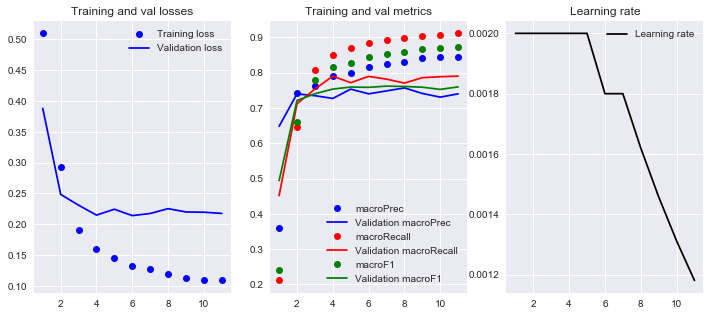

In [45]:
model1a.plot()

---

### Convolutions

In [19]:
# embedding: keras layer, trained
# structure: convolution layers

layers2a = [Conv1D(20, 4),
            Conv1D(20, 4),
            AveragePooling1D(4,2),
            Flatten()
           ]

model2a = BlackBox(layers=layers2a, loss=my_loss, metrics=my_metrics,\
                   epochs=20,\
                   embedd = embedd_file_1,\
                   embedd_dims=[num_words, 50, padded_length])
model2a.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 679, 50)           13865200  
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 676, 20)           4020      
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 673, 20)           1620      
_________________________________________________________________
average_pooling1d_2 (Average (None, 335, 20)           0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 6700)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 40206     
Total params: 13,911,046
Trainable params: 45,846
Non-trainable params: 13,865,200
___________________________________________________________

In [16]:
model2a.fit() # my_loss unmodified

Train on 50000 samples, validate on 50000 samples
Epoch 1/20
Embedding trainable: False
50000/50000 [==============================] - 74s 1ms/step - loss: 0.3134 - macroPrec: 0.6766 - macroF1: 0.5839 - macroRecall: 0.5726 - val_loss: 0.2073 - val_macroPrec: 0.7380 - val_macroF1: 0.7692 - val_macroRecall: 0.8180
Epoch 2/20
Embedding trainable: False
50000/50000 [==============================] - 74s 1ms/step - loss: 0.1616 - macroPrec: 0.7587 - macroF1: 0.8048 - macroRecall: 0.8779 - val_loss: 0.2121 - val_macroPrec: 0.7309 - val_macroF1: 0.7716 - val_macroRecall: 0.8344
Epoch 3/20
Embedding trainable: False
50000/50000 [==============================] - 73s 1ms/step - loss: 0.1454 - macroPrec: 0.7766 - macroF1: 0.8222 - macroRecall: 0.8905 - val_loss: 0.2021 - val_macroPrec: 0.7311 - val_macroF1: 0.7705 - val_macroRecall: 0.8316
Epoch 4/20
Embedding trainable: True
50000/50000 [==============================] - 74s 1ms/step - loss: 0.1330 - macroPrec: 0.7885 - macroF1: 0.8339 - macroR

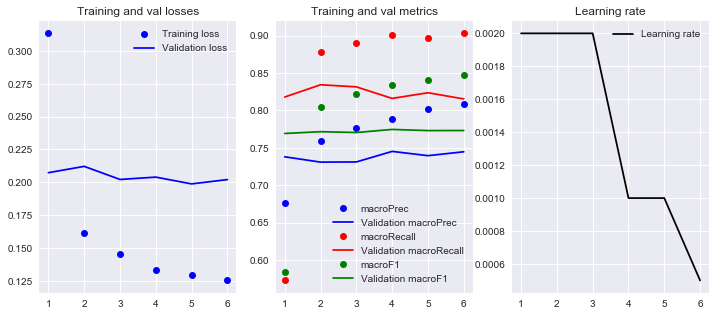

In [17]:
model2a.plot() # my_loss

In [20]:
model2a.fit() # my_loss modified

Train on 50000 samples, validate on 50000 samples
Epoch 1/20
Embedding trainable: False
50000/50000 [==============================] - 76s 2ms/step - loss: 0.4637 - macroPrec: 0.2790 - macroF1: 0.1316 - macroRecall: 0.1111 - val_loss: 0.3556 - val_macroPrec: 0.7000 - val_macroF1: 0.4413 - val_macroRecall: 0.3845
Epoch 2/20
Embedding trainable: False
50000/50000 [==============================] - 74s 1ms/step - loss: 0.2634 - macroPrec: 0.8590 - macroF1: 0.6538 - macroRecall: 0.5974 - val_loss: 0.2137 - val_macroPrec: 0.7927 - val_macroF1: 0.7392 - val_macroRecall: 0.7057
Epoch 3/20
Embedding trainable: False
50000/50000 [==============================] - 75s 1ms/step - loss: 0.1631 - macroPrec: 0.8044 - macroF1: 0.7950 - macroRecall: 0.7938 - val_loss: 0.1754 - val_macroPrec: 0.7637 - val_macroF1: 0.7647 - val_macroRecall: 0.7720
Epoch 4/20
Embedding trainable: False
50000/50000 [==============================] - 74s 1ms/step - loss: 0.1381 - macroPrec: 0.8018 - macroF1: 0.8140 - macro

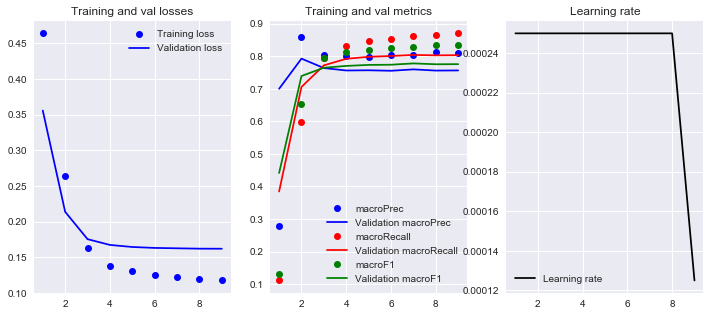

In [21]:
model2a.plot()

---

### Recurrent NNEts

In [26]:
# embedding: keras layer, trained
# structure: birectional fully connected RNN layer + dense

layers3a = [Bidirectional(SimpleRNN(40, dropout=0.1, recurrent_dropout=0.1)),
           ]

model3a = BlackBox(layers=layers3a, loss=my_loss, metrics=my_metrics,\
                   epochs=20,\
                   embedd = embedd_file_1,\
                   embedd_dims=[num_words, 50, padded_length])
model3a.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 679, 50)           13865200  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 80)                7280      
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 486       
Total params: 13,872,966
Trainable params: 7,766
Non-trainable params: 13,865,200
_________________________________________________________________


In [27]:
model3a.fit()

Train on 50000 samples, validate on 50000 samples
Epoch 1/20
Embedding trainable: False
50000/50000 [==============================] - 131s 3ms/step - loss: 0.5333 - macroPrec: 0.2805 - macroF1: 0.0145 - macroRecall: 0.0086 - val_loss: 0.5164 - val_macroPrec: 0.3025 - val_macroF1: 0.0089 - val_macroRecall: 0.0050
Epoch 2/20
Embedding trainable: False
50000/50000 [==============================] - 134s 3ms/step - loss: 0.5127 - macroPrec: 0.3366 - macroF1: 0.0316 - macroRecall: 0.0174 - val_loss: 0.4941 - val_macroPrec: 0.3707 - val_macroF1: 0.0548 - val_macroRecall: 0.0301
Epoch 3/20
Embedding trainable: False
50000/50000 [==============================] - 145s 3ms/step - loss: 0.4937 - macroPrec: 0.4369 - macroF1: 0.0868 - macroRecall: 0.0501 - val_loss: 0.4744 - val_macroPrec: 0.3831 - val_macroF1: 0.1490 - val_macroRecall: 0.0992
Epoch 4/20
Embedding trainable: False
50000/50000 [==============================] - 144s 3ms/step - loss: 0.4772 - macroPrec: 0.4519 - macroF1: 0.1531 - m

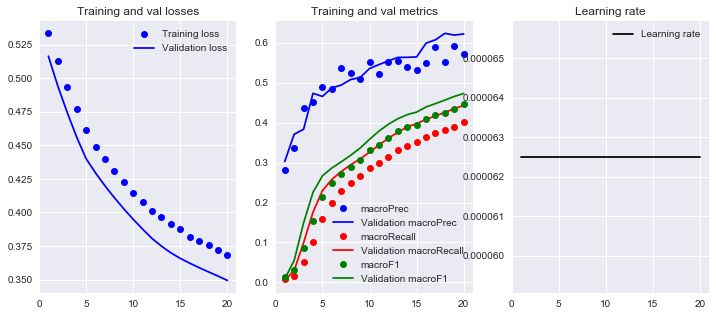

In [28]:
model3a.plot()

---

### Short-Long-Term-Memory

In [ ]:
# embedding: keras layer, trained
# structure: birectional fully connected RNN layer + dense

layers4a = [Bidirectional(LSTM(60, dropout=0.1, recurrent_dropout=0.1)),
            Dense(20, activation='relu')
           ]

model4a = BlackBox(layers=layers4a, loss=my_loss, metrics=my_metrics,\
                   epochs=20,\
                   embedd = embedd_file,\
                   embedd_dims=[num_words, 50, padded_length])
model4a.summary()

In [ ]:
model4.plot()

---
---

# Loss = ...

---

### Dense nets

---

---

---